In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import glob
import sys, copy
import numpy as np
import pyccl as ccl
#sys.path.append('../modules/')
import ModelClusterObservables
sys.path.append('../modules/')
import halo._halo_abundance
import matplotlib.pyplot as plt
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
params = {
     "font.family": "serif",
     "font.serif": ["Times", "Times New Roman", "DejaVu Serif"],
     "axes.labelsize": 10,
     "font.size": 10,
     "legend.fontsize": 8,
     "xtick.labelsize": 8,
     "ytick.labelsize": 8,
     "text.usetex": True,
     #"figure.figsize": [3.386, 3.386],
     "figure.dpi": 300,
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.05,
     "axes.linewidth": 0.8,
     "xtick.major.width": 0.8,
     "ytick.major.width": 0.8,
     "xtick.direction": "in",
     "ytick.direction": "in",
    "xtick.top": True,
     "ytick.right": True,
 }
plt.rcParams.update(params)

# Define Count and lensing mass models

In [2]:
import configparser
default_config_capish = configparser.ConfigParser()
default_config_capish.read('../config/capish_internal_validation.ini')
default_config_capish['summary_statistics']['richness_edges'] = '20, 26, 34, 44, 58, 76, 100'
default_config_capish['summary_statistics']['redshift_edges'] = '0.2, 0.6'

In [3]:
ClusterAbundanceObject = ModelClusterObservables.UniversePrediction( default_config=default_config_capish )

In [4]:
params_default = ClusterAbundanceObject.params_default 
cosmo_fid = params_default['CCL_cosmology']
params_new = params_default
compute_new= {'compute_dNdzdlogMdOmega':False,'compute_richness_mass_relation':False, 
               'compute_completeness':False, 'compute_purity':False ,'compute_halo_bias':True,
             'compute_dNdzdlogMdOmega_log_slope': False}
adds_new={'add_purity':False, 'add_completeness':False}

In [5]:
skyarea = ClusterAbundanceObject.HaloAbundanceObject.sky_area
fsky = skyarea/(4*np.pi)

In [6]:
Nfid = ClusterAbundanceObject.model_count(params_new, compute_new, adds_new)

In [7]:
Nbfid = ClusterAbundanceObject.model_bias(params_new, compute_new, adds_new)
bfid = Nbfid/Nfid

In [8]:
SSC = halo._halo_abundance.HaloAbundance()
cosmo_fid = ccl.Cosmology( Omega_c = float( default_config_capish['halo_catalogue']['Omega_c_fiducial'] ), 
                               Omega_b = float( default_config_capish['halo_catalogue']['Omega_b_fiducial'] ), 
                               h = float( default_config_capish['halo_catalogue']['h_fiducial'] ), 
                               sigma8 = float( default_config_capish['halo_catalogue']['sigma_8_fiducial'] ), 
                               n_s=float( default_config_capish['halo_catalogue']['n_s_fiducial'] ) )
Sij = SSC.compute_theoretical_Sij([[0.2, 0.6]], cosmo_fid, fsky, S_ij_type = 'full_sky_rescaled_approx', )

In [9]:
var_th = Nfid + Nfid **2 * bfid **2 * Sij[0]

[[16749.525 ]
 [ 8674.7325]
 [ 3960.01  ]
 [ 1828.8475]
 [  665.805 ]
 [  215.345 ]]


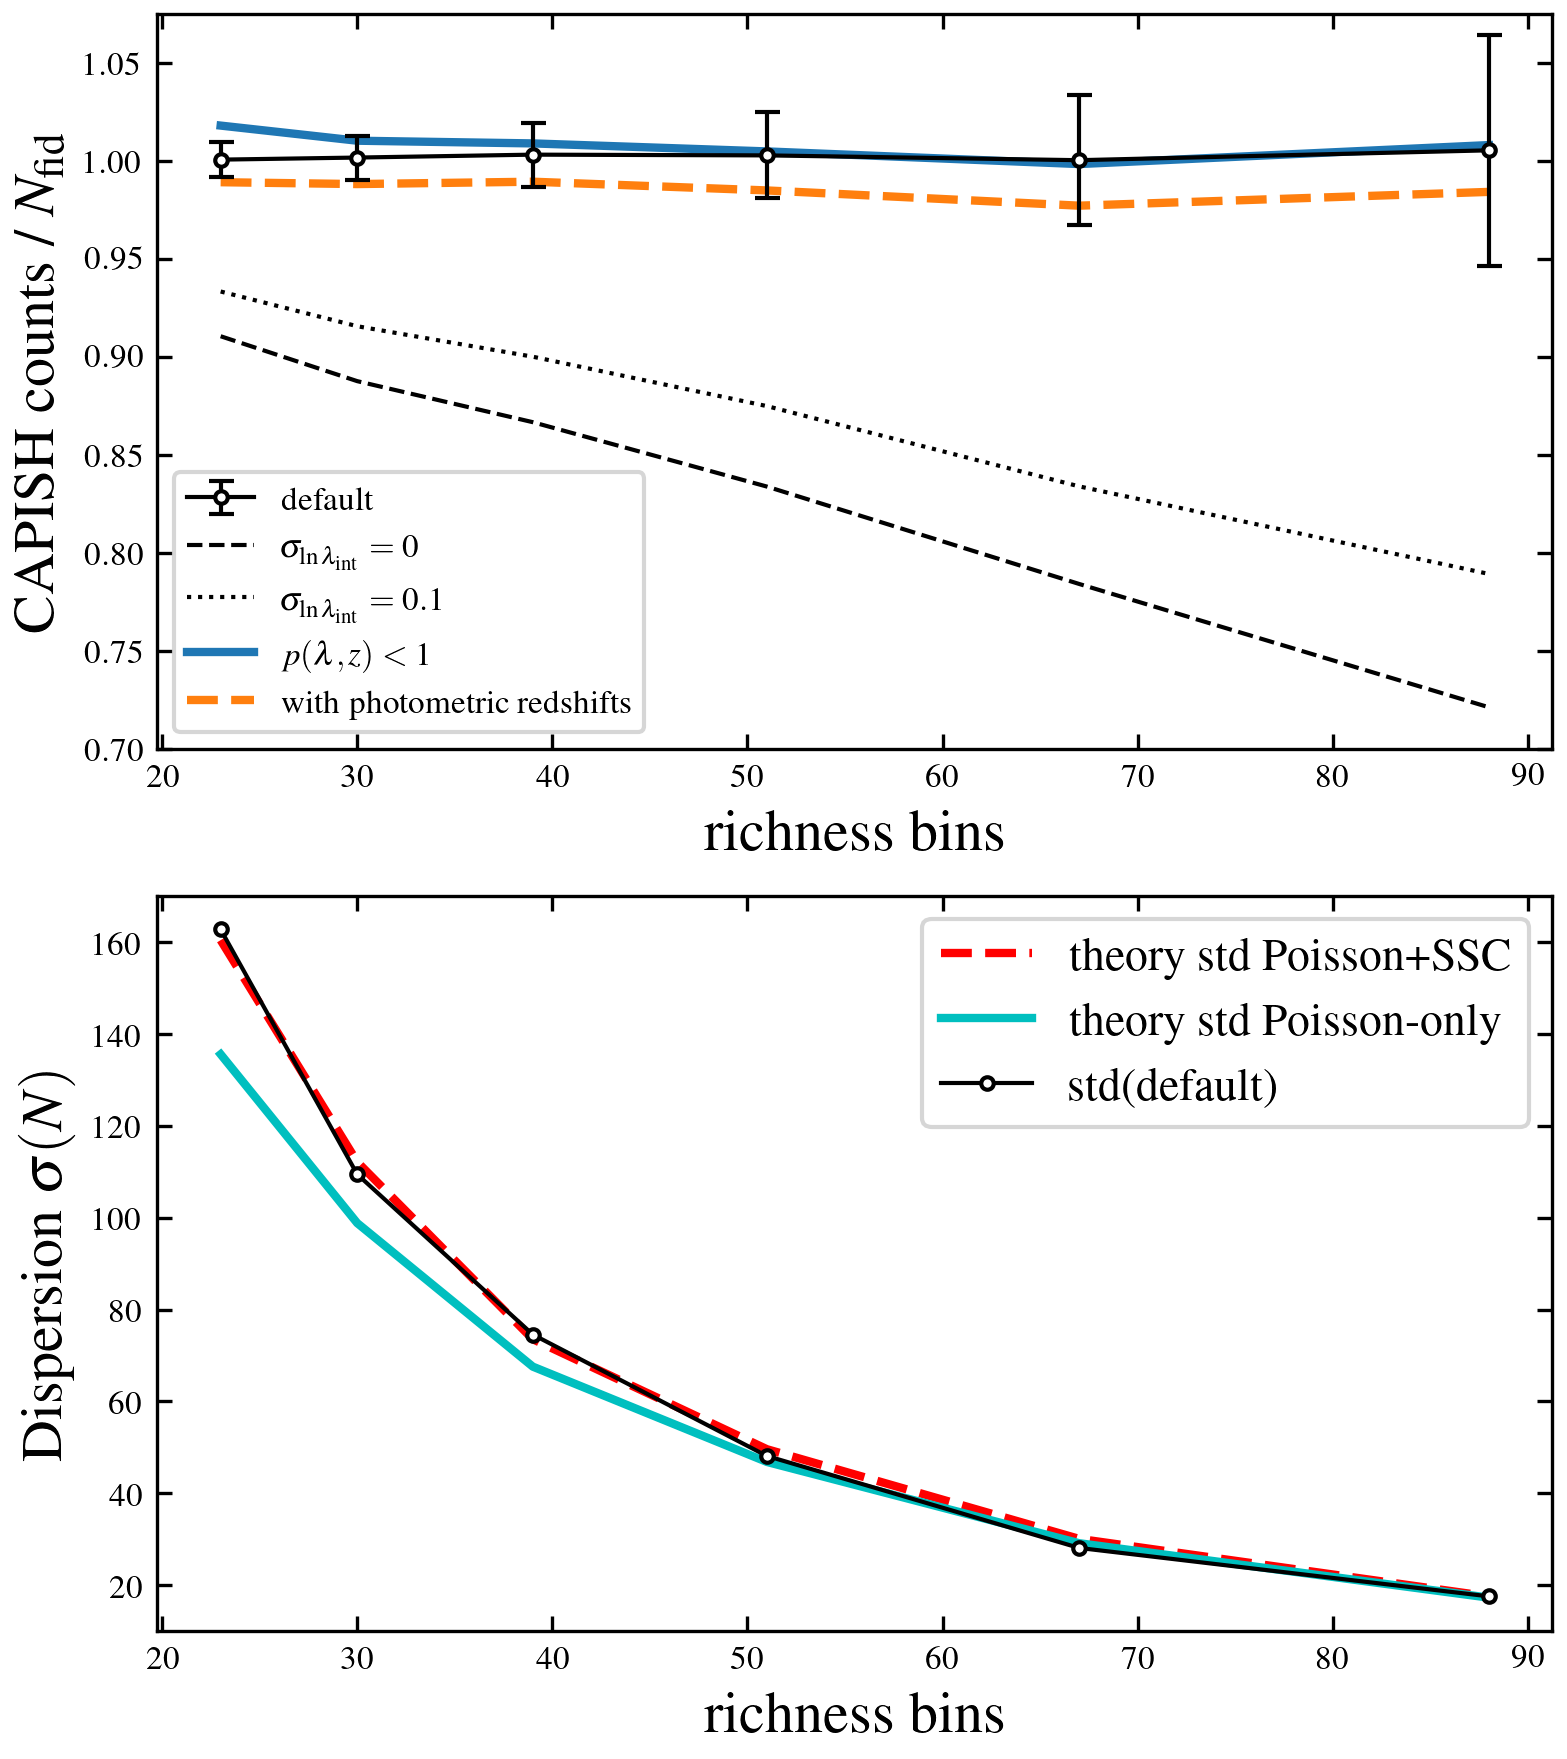

In [17]:
plt.figure(figsize=(6,7))
plt.subplot(211)


std_default_capish = np.std(
    np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,0], axis=0,)

res_default_capish_10 = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[200:400,0], axis=0)
res_photoz = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/with_photoz.pkl'))[:,0], axis=0)
not_pure = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/not_pure.pkl'))[:,0], axis=0)
no_sigma_lamda = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise_no_sigmalambda.pkl'))[:,0], axis=0)
print(no_sigma_lamda)
small_sigma_lamda = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise_smaller_sigmalambda.pkl'))[:,0], axis=0)
#not_complete = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/incomplete.pkl'))[:,0], axis=0)
#not_pure_not_complete = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/not_pure_and_incomplete.pkl'))[:,0], axis=0)
plt.errorbar(ClusterAbundanceObject.richness_centers, (res_default_capish_10[:,0])/Nfid[:,0], 
            std_default_capish[:,0]/Nfid[:,0], capsize=3, markerfacecolor='w',  c='k', linewidth=1, fmt = '-', marker='o', markersize=3, label=r'default')
plt.errorbar(ClusterAbundanceObject.richness_centers, (no_sigma_lamda[:,0] )/Nfid[:,0], c='k',fmt='--', lw=1, label = r'$\sigma_{\rm \ln\lambda_{\rm int}}=0$')
plt.errorbar(ClusterAbundanceObject.richness_centers, (small_sigma_lamda[:,0] )/Nfid[:,0],c='k', fmt=':', lw=1, label = r'$\sigma_{\rm \ln\lambda_{\rm int}}=0.1$')
plt.errorbar(ClusterAbundanceObject.richness_centers, (not_pure )/Nfid, lw=2, label = r'$p(\lambda, z) < 1$', zorder=0)
#plt.plot(ClusterAbundanceObject.richness_centers, (not_complete)/Nfid, '--b', lw=2,label = r'$c(m,z) < 1$')
#plt.plot(ClusterAbundanceObject.richness_centers, (not_pure_not_complete)/Nfid, '-b', lw=2, 
#                                                     label = r'$p(\lambda, z) < 1 \& c(m,z) < 1$')
plt.errorbar(ClusterAbundanceObject.richness_centers, (res_photoz)/Nfid,fmt='--', zorder=0, lw=2,label = 'with photometric redshifts')
plt.ylim(0.7, 1+0.075)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel(r'CAPISH counts / $N_{\rm fid}$', fontsize=14)
plt.legend()

plt.subplot(212)
plt.errorbar(ClusterAbundanceObject.richness_centers, std_default_capish, markerfacecolor='w',
             c='k', lw=1,  fmt = '-', marker='o', markersize=3, label = 'std(default)', zorder=10)
#plt.plot(ClusterAbundanceObject.richness_centers, std_photoz, '-b', lw=3, label = 'std(default)')
plt.plot(ClusterAbundanceObject.richness_centers, np.sqrt(var_th), '--r', lw=2, label = 'theory std Poisson+SSC')
plt.plot(ClusterAbundanceObject.richness_centers, np.sqrt(Nfid), '-c', lw=2, label = 'theory std Poisson-only')
plt.legend(fontsize=11)
plt.xlabel('richness')
#plt.ylim(10, 180)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel(r'Dispersion $\sigma(N)$', fontsize=14)
#plt.yscale('log')
plt.savefig(f'count_bias.png', dpi = 300, bbox_inches='tight',)

In [11]:
gamma = 1
NMfid_gamma, Nth_m = ClusterAbundanceObject.model_mass(params_new, compute_new, adds_new, 
                                                       gamma=gamma,add_WL_weight = True)
Mfid = (NMfid_gamma/Nth_m)**(1/gamma)

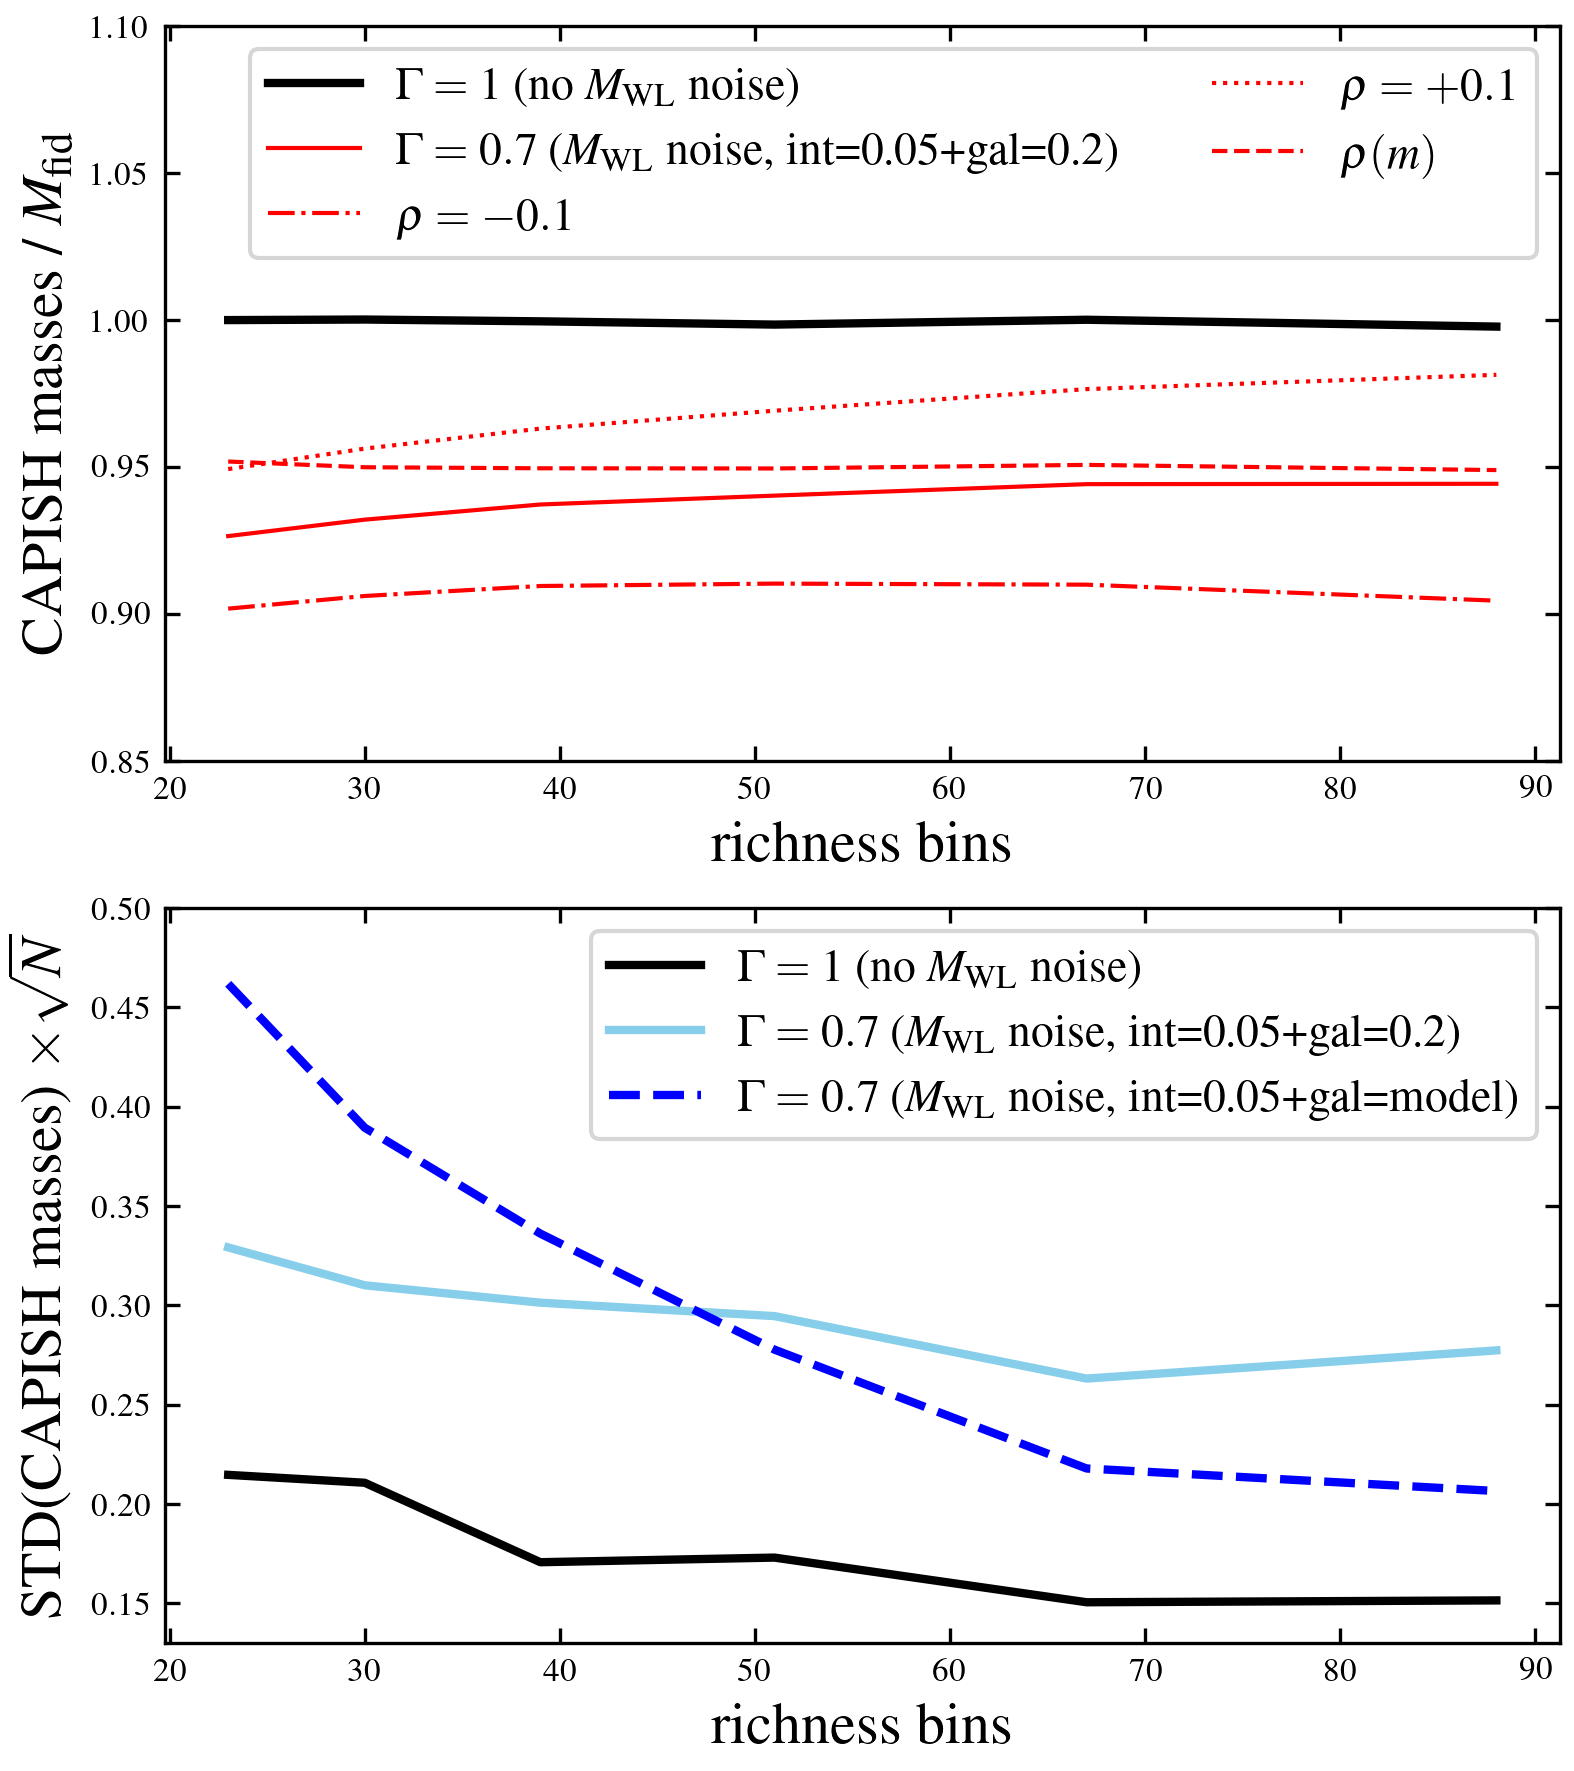

In [16]:
plt.figure(figsize=(6,7))
plt.subplot(211)

res_default_capish_10 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_10_WL_noise = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_WL_noise.pkl'))[:,1], axis=0)

res_default_capish_07 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07_WL_noise = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise.pkl'))[:,1], axis=0)
res_photoz = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/with_photoz.pkl'))[:,1], axis=0)
rho_m01 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_m0.1.pkl'))[:,1], axis=0)
rho_p01 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.1.pkl'))[:,1], axis=0)
rho_p02 = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_p0.2.pkl'))[:,1], axis=0)
rho_model = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/rho_model.pkl'))[:,1], axis=0)
not_pure = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure.pkl'))[:,1], axis=0)
not_complete = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/incomplete.pkl'))[:,1], axis=0)
not_pure_not_complete = np.mean(10**np.array(load('./capish_sims_at_fiducial_cosmology/not_pure_and_incomplete.pkl'))[:,1], axis=0)
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10)/Mfid, '-k',  lw=2, label=r'$\Gamma=1$ (no $M_{\rm WL}$ noise)')
#plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10_WL_noise)/Mfid, '--k',  lw=2, label=r'$\Gamma=1$ ($M_{\rm WL}$ noise)')

#plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07)/Mfid , '-', c='darkorange', lw=2,label = r'$\Gamma=0.7$ (no $M_{\rm WL}$ noise)')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07_WL_noise)/Mfid, c='r', lw=1, label =  r'$\Gamma=0.7$ ($M_{\rm WL}$ noise, int=0.05+gal=0.2)')

plt.plot(ClusterAbundanceObject.richness_centers, (rho_m01)/Mfid , '-.r', lw=1,label = r'$\rho=-0.1$')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_p01)/Mfid, ':r', lw=1, label = r'$\rho=+0.1$')
plt.plot(ClusterAbundanceObject.richness_centers, (rho_model)/Mfid , '--r', lw=1, label = r'$\rho(m)$')

plt.legend(fontsize=11, ncols=2)
plt.ylim(0.85, 1+0.1)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel(R'CAPISH masses / $M_{\rm fid}$', fontsize=14)

plt.subplot(212)
res_default_capish_10_N = np.mean(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,0], axis=0)
res_default_capish_10 = np.std(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_1.0_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07 = np.std(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_noWL_noise.pkl'))[:,1], axis=0)
res_default_capish_07_WL_noise = np.std(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise.pkl'))[:,1], axis=0)
res_default_capish_07_WL_noise_model = np.std(np.array(load('./capish_sims_at_fiducial_cosmology/default_capish_Gamma_0.7_WL_noise_model.pkl'))[:,1], axis=0)
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_10) * np.sqrt(res_default_capish_10_N), '-k',  lw=2, label=r'$\Gamma=1$ (no $M_{\rm WL}$ noise)')
#plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07)* np.sqrt(res_default_capish_10_N), '-', c='darkorange', lw=2,label = r'$\Gamma=0.7$ (no $M_{\rm WL}$ noise)')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07_WL_noise)* np.sqrt(res_default_capish_10_N), c='skyblue', lw=2, label =  r'$\Gamma=0.7$ ($M_{\rm WL}$ noise, int=0.05+gal=0.2)')
plt.plot(ClusterAbundanceObject.richness_centers, (res_default_capish_07_WL_noise_model)* np.sqrt(res_default_capish_10_N), c='blue', ls='--', lw=2, label =  r'$\Gamma=0.7$ ($M_{\rm WL}$ noise, int=0.05+gal=model)')


plt.ylabel(r'$\sigma(\log_{10} M)$', fontsize=14)
plt.legend(fontsize=11, ncols=1)
#plt.yscale('log')
plt.ylim(0.13, 0.50)
plt.xlabel('richness bins', fontsize=14)
plt.ylabel(R'STD(CAPISH masses) $\times \sqrt{N}$', fontsize=14)
plt.savefig(f'mass_bias.png', bbox_inches='tight', dpi=300)